## 1. Import Required Libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 100)

# Set visualization style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print(" Libraries imported successfully")

 Libraries imported successfully


## 2. Load and Explore the Data

In [18]:
# Load the data
df = pd.read_csv('QVI_data.csv')
print(f" Loaded data: {df.shape[0]} rows, {df.shape[1]} columns")

# Display first few rows
display(df.head())

 Loaded data: 264834 rows, 12 columns


,LYLTY_CARD_NBR,DATE,STORE_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,2018-10-17,1,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175,NATURAL,YOUNG SINGLES/COUPLES,Premium
1,1002,2018-09-16,1,2,58,Red Rock Deli Chikn&Garlic Aioli 150g,1,2.7,150,RRD,YOUNG SINGLES/COUPLES,Mainstream
2,1003,2019-03-07,1,3,52,Grain Waves Sour Cream&Chives 210G,1,3.6,210,GRNWVES,YOUNG FAMILIES,Budget
3,1003,2019-03-08,1,4,106,Natural ChipCo Hony Soy Chckn175g,1,3.0,175,NATURAL,YOUNG FAMILIES,Budget
4,1004,2018-11-02,1,5,96,WW Original Stacked Chips 160g,1,1.9,160,WOOLWORTHS,OLDER SINGLES/COUPLES,Mainstream


In [19]:
# Data info
print("Dataset Info:")
df.info()

print("\nBasic Statistics:")
display(df.describe())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264834 entries, 0 to 264833
Data columns (total 12 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   LYLTY_CARD_NBR    264834 non-null  int64  
 1   DATE              264834 non-null  object 
 2   STORE_NBR         264834 non-null  int64  
 3   TXN_ID            264834 non-null  int64  
 4   PROD_NBR          264834 non-null  int64  
 5   PROD_NAME         264834 non-null  object 
 6   PROD_QTY          264834 non-null  int64  
 7   TOT_SALES         264834 non-null  float64
 8   PACK_SIZE         264834 non-null  int64  
 9   BRAND             264834 non-null  object 
 10  LIFESTAGE         264834 non-null  object 
 11  PREMIUM_CUSTOMER  264834 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 24.2+ MB

Basic Statistics:


,LYLTY_CARD_NBR,STORE_NBR,TXN_ID,PROD_NBR,PROD_QTY,TOT_SALES,PACK_SIZE
count,2.648340e+05,264834.000000,2.648340e+05,264834.000000,264834.000000,264834.000000,264834.000000
mean,1.355488e+05,135.079423,1.351576e+05,56.583554,1.905813,7.299346,182.425512
std,8.057990e+04,76.784063,7.813292e+04,32.826444,0.343436,2.527241,64.325148
min,1.000000e+03,1.000000,1.000000e+00,1.000000,1.000000,1.500000,70.000000
25%,7.002100e+04,70.000000,6.760050e+04,28.000000,2.000000,5.400000,150.000000
50%,1.303570e+05,130.000000,1.351365e+05,56.000000,2.000000,7.400000,170.000000
75%,2.030940e+05,203.000000,2.026998e+05,85.000000,2.000000,9.200000,175.000000
max,2.373711e+06,272.000000,2.415841e+06,114.000000,5.000000,29.500000,380.000000


In [20]:
# Convert DATE to datetime
df['DATE'] = pd.to_datetime(df['DATE'])
print(f"✓ Converted DATE to datetime")
print(f"  Date range: {df['DATE'].min()} to {df['DATE'].max()}")

# Create YEARMONTH column for aggregation
df['YEARMONTH'] = df['DATE'].dt.to_period('M')
print(f"✓ Created YEARMONTH column")

✓ Converted DATE to datetime
  Date range: 2018-07-01 00:00:00 to 2019-06-30 00:00:00
✓ Created YEARMONTH column


In [21]:
# Check trial stores
trial_stores = [77, 86, 88]
print(f"Trial Stores: {trial_stores}")
print(f"\nTotal unique stores in dataset: {df['STORE_NBR'].nunique()}")
print(f"Store range: {df['STORE_NBR'].min()} to {df['STORE_NBR'].max()}")

# Check if trial stores exist in data
for store in trial_stores:
    count = len(df[df['STORE_NBR'] == store])
    print(f"  Store {store}: {count} transactions")

Trial Stores: [77, 86, 88]

Total unique stores in dataset: 272
Store range: 1 to 272
  Store 77: 563 transactions
  Store 86: 1538 transactions
  Store 88: 1873 transactions


## 3. Calculate Monthly Metrics by Store

We'll calculate:
- **Total sales revenue**: Sum of TOT_SALES
- **Total number of customers**: Unique count of LYLTY_CARD_NBR
- **Average number of transactions per customer**: Total transactions / Total customers

In [22]:
# Calculate monthly metrics by store
monthly_store_metrics = df.groupby(['STORE_NBR', 'YEARMONTH']).agg({
    'TOT_SALES': 'sum',                    # Total sales revenue
    'LYLTY_CARD_NBR': 'nunique',           # Total number of customers
    'TXN_ID': 'count'                      # Total number of transactions
}).reset_index()

monthly_store_metrics.columns = ['STORE_NBR', 'YEARMONTH', 'total_sales', 'total_customers', 'total_transactions']

# Calculate average transactions per customer
monthly_store_metrics['avg_transactions_per_customer'] = (
    monthly_store_metrics['total_transactions'] / monthly_store_metrics['total_customers']
).round(2)

# Calculate average sales per transaction
monthly_store_metrics['avg_sales_per_transaction'] = (
    monthly_store_metrics['total_sales'] / monthly_store_metrics['total_transactions']
).round(2)

print("✓ Calculated monthly metrics by store")
print(f"  Shape: {monthly_store_metrics.shape}")
display(monthly_store_metrics.head(10))

✓ Calculated monthly metrics by store
  Shape: (3169, 7)


,STORE_NBR,YEARMONTH,total_sales,total_customers,total_transactions,avg_transactions_per_customer,avg_sales_per_transaction
0,1,2018-07,206.9,49,52,1.06,3.98
1,1,2018-08,176.1,42,43,1.02,4.10
2,1,2018-09,278.8,59,62,1.05,4.50
3,1,2018-10,188.1,44,45,1.02,4.18
4,1,2018-11,192.6,46,47,1.02,4.10
5,1,2018-12,189.6,42,47,1.12,4.03
6,1,2019-01,154.8,35,36,1.03,4.30
7,1,2019-02,225.4,52,55,1.06,4.10
8,1,2019-03,192.9,45,49,1.09,3.94
9,1,2019-04,192.9,42,43,1.02,4.49


In [23]:
# Check trial stores metrics
print("Trial Stores Monthly Metrics Sample:")
for store in trial_stores:
    store_data = monthly_store_metrics[monthly_store_metrics['STORE_NBR'] == store]
    print(f"\nStore {store}: {len(store_data)} months of data")
    display(store_data.head())

Trial Stores Monthly Metrics Sample:

Store 77: 12 months of data


,STORE_NBR,YEARMONTH,total_sales,total_customers,total_transactions,avg_transactions_per_customer,avg_sales_per_transaction
880,77,2018-07,296.8,51,55,1.08,5.40
881,77,2018-08,255.5,47,48,1.02,5.32
882,77,2018-09,225.2,42,44,1.05,5.12
883,77,2018-10,204.5,37,38,1.03,5.38
884,77,2018-11,245.3,41,44,1.07,5.58



Store 86: 12 months of data


,STORE_NBR,YEARMONTH,total_sales,total_customers,total_transactions,avg_transactions_per_customer,avg_sales_per_transaction
977,86,2018-07,892.20,99,126,1.27,7.08
978,86,2018-08,764.05,94,112,1.19,6.82
979,86,2018-09,914.60,103,129,1.25,7.09
980,86,2018-10,948.40,109,138,1.27,6.87
981,86,2018-11,918.00,100,127,1.27,7.23



Store 88: 12 months of data


,STORE_NBR,YEARMONTH,total_sales,total_customers,total_transactions,avg_transactions_per_customer,avg_sales_per_transaction
1001,88,2018-07,1310.0,129,153,1.19,8.56
1002,88,2018-08,1323.8,131,160,1.22,8.27
1003,88,2018-09,1423.0,124,159,1.28,8.95
1004,88,2018-10,1352.4,123,158,1.28,8.56
1005,88,2018-11,1382.8,130,157,1.21,8.81


## 4. Define Trial Period

Based on typical retail trials, we'll assume:
- **Pre-trial period**: First part of the data period
- **Trial period**: Last 3 months of the data (we'll identify this from the data)

Let's examine the data timeline to determine the appropriate trial period.

In [24]:
# Get date range
min_month = monthly_store_metrics['YEARMONTH'].min()
max_month = monthly_store_metrics['YEARMONTH'].max()

print(f"Data Period: {min_month} to {max_month}")
print(f"Total months: {(max_month - min_month).n + 1}")

# Define trial period (typically last 3 months, but let's use Feb-Apr 2019 as common retail trial period)
trial_months = pd.period_range(start='2019-02', end='2019-04', freq='M')
pre_trial_months = monthly_store_metrics[
    monthly_store_metrics['YEARMONTH'] < trial_months[0]
]['YEARMONTH'].unique()

print(f"\nTrial Period: {trial_months[0]} to {trial_months[-1]}")
print(f"Pre-trial Period: {pre_trial_months[0]} to {pre_trial_months[-1]}")
print(f"Pre-trial months: {len(pre_trial_months)}")

Data Period: 2018-07 to 2019-06
Total months: 12

Trial Period: 2019-02 to 2019-04
Pre-trial Period: 2018-07 to 2019-01
Pre-trial months: 7


## 5. Create Control Store Selection Function

We'll use two similarity measures:
1. **Pearson Correlation**: Measures how similarly two stores' sales patterns move together
2. **Magnitude Distance**: Measures how close two stores' absolute values are

The formula for magnitude distance is: `1 - (|observed - minimum|) / (maximum - minimum)`

In [25]:
def calculate_correlation_score(trial_store, control_store, metric='total_sales'):
    """
    Calculate Pearson correlation between trial and control store for pre-trial period
    """
    # Get pre-trial data
    trial_data = monthly_store_metrics[
        (monthly_store_metrics['STORE_NBR'] == trial_store) &
        (monthly_store_metrics['YEARMONTH'].isin(pre_trial_months))
    ].sort_values('YEARMONTH')[metric].values
    
    control_data = monthly_store_metrics[
        (monthly_store_metrics['STORE_NBR'] == control_store) &
        (monthly_store_metrics['YEARMONTH'].isin(pre_trial_months))
    ].sort_values('YEARMONTH')[metric].values
    
    if len(trial_data) == len(control_data) and len(trial_data) > 1:
        correlation, _ = pearsonr(trial_data, control_data)
        return correlation
    return 0

def calculate_magnitude_distance(trial_store, control_store, metric='total_sales'):
    """
    Calculate magnitude distance: 1 - (observed - min) / (max - min)
    Higher score means more similar in absolute magnitude
    """
    # Get average pre-trial values
    trial_avg = monthly_store_metrics[
        (monthly_store_metrics['STORE_NBR'] == trial_store) &
        (monthly_store_metrics['YEARMONTH'].isin(pre_trial_months))
    ][metric].mean()
    
    control_avg = monthly_store_metrics[
        (monthly_store_metrics['STORE_NBR'] == control_store) &
        (monthly_store_metrics['YEARMONTH'].isin(pre_trial_months))
    ][metric].mean()
    
    # Get min and max across all stores
    all_avgs = monthly_store_metrics[
        monthly_store_metrics['YEARMONTH'].isin(pre_trial_months)
    ].groupby('STORE_NBR')[metric].mean()
    
    min_val = all_avgs.min()
    max_val = all_avgs.max()
    
    if max_val == min_val:
        return 1
    
    observed_distance = abs(control_avg - trial_avg)
    normalized_distance = observed_distance / (max_val - min_val)
    magnitude_score = 1 - normalized_distance
    
    return max(0, magnitude_score)  # Ensure non-negative

def find_control_store(trial_store, exclude_stores=None):
    """
    Find the best control store for a trial store based on:
    - Sales correlation
    - Customer correlation  
    - Magnitude distance for both metrics
    """
    if exclude_stores is None:
        exclude_stores = trial_stores
    
    all_stores = monthly_store_metrics['STORE_NBR'].unique()
    candidate_stores = [s for s in all_stores if s not in exclude_stores]
    
    results = []
    
    for control_store in candidate_stores:
        # Calculate scores for sales
        sales_corr = calculate_correlation_score(trial_store, control_store, 'total_sales')
        sales_mag = calculate_magnitude_distance(trial_store, control_store, 'total_sales')
        
        # Calculate scores for customers
        customers_corr = calculate_correlation_score(trial_store, control_store, 'total_customers')
        customers_mag = calculate_magnitude_distance(trial_store, control_store, 'total_customers')
        
        # Combined score (weighted average)
        combined_score = (
            0.3 * sales_corr +
            0.3 * sales_mag +
            0.2 * customers_corr +
            0.2 * customers_mag
        )
        
        results.append({
            'control_store': control_store,
            'sales_correlation': round(sales_corr, 4),
            'sales_magnitude': round(sales_mag, 4),
            'customers_correlation': round(customers_corr, 4),
            'customers_magnitude': round(customers_mag, 4),
            'combined_score': round(combined_score, 4)
        })
    
    results_df = pd.DataFrame(results).sort_values('combined_score', ascending=False)
    return results_df

print("✓ Control store selection functions defined")

✓ Control store selection functions defined


## 6. Select Control Stores for Each Trial Store

In [26]:
# Find control stores for each trial store
control_store_mapping = {}

for trial_store in trial_stores:
    print(f"\n{'='*80}")
    print(f"Finding control store for Trial Store {trial_store}")
    print(f"{'='*80}")
    
    # Get top candidates
    candidates = find_control_store(trial_store)
    
    print(f"\nTop 10 Control Store Candidates:")
    display(candidates.head(10))
    
    # Select best control store
    best_control = candidates.iloc[0]['control_store']
    control_store_mapping[trial_store] = best_control
    
    print(f"\n✓ Selected Control Store: {best_control}")
    print(f"   Combined Score: {candidates.iloc[0]['combined_score']}")

print(f"\n\n{'='*80}")
print("CONTROL STORE MAPPING:")
print(f"{'='*80}")
for trial, control in control_store_mapping.items():
    print(f"  Trial Store {trial} → Control Store {control}")


Finding control store for Trial Store 77

Top 10 Control Store Candidates:


,control_store,sales_correlation,sales_magnitude,customers_correlation,customers_magnitude,combined_score
229,233,0.9038,0.9962,0.9904,0.9989,0.9678
40,41,0.7832,0.9690,0.8442,0.9989,0.8943
16,17,0.8427,0.8935,0.7473,0.9926,0.8688
49,50,0.7639,0.9808,0.6074,0.9534,0.8356
111,115,0.6892,0.9400,0.7189,0.9788,0.8283
163,167,0.6571,0.9634,0.7179,0.9852,0.8268
250,254,0.5771,0.9308,0.9162,0.9545,0.8265
82,84,0.6843,0.8495,0.8586,0.9450,0.8209
261,265,0.6398,0.9743,0.5735,0.9926,0.7974
230,234,0.6963,0.9016,0.5824,0.9947,0.7948



✓ Selected Control Store: 233.0
   Combined Score: 0.9678

Finding control store for Trial Store 86

Top 10 Control Store Candidates:


,control_store,sales_correlation,sales_magnitude,customers_correlation,customers_magnitude,combined_score
151,155,0.8779,0.9815,0.9429,1.0000,0.9464
105,109,0.7883,0.9884,0.7708,0.9968,0.8865
110,114,0.7344,0.9529,0.8553,0.9534,0.8680
134,138,0.7599,0.9801,0.7497,0.9778,0.8675
221,225,0.6175,0.9971,0.7338,0.9968,0.8305
218,222,0.7951,0.9857,0.4582,0.9587,0.8176
143,147,0.5455,0.9585,0.6411,0.9407,0.7675
168,172,0.5245,0.9994,0.5710,0.9757,0.7665
74,75,0.7063,0.8197,0.5781,0.9429,0.7620
55,56,0.5514,0.8940,0.7035,0.8857,0.7515



✓ Selected Control Store: 155.0
   Combined Score: 0.9464

Finding control store for Trial Store 88

Top 10 Control Store Candidates:


,control_store,sales_correlation,sales_magnitude,customers_correlation,customers_magnitude,combined_score
174,178,0.7319,0.7224,0.9395,0.8360,0.7914
233,237,0.3085,0.9986,0.9473,0.9947,0.7805
197,201,0.4927,0.8838,0.5113,0.9270,0.7006
109,113,0.4958,0.7105,0.8626,0.8021,0.6948
68,69,0.4500,0.7334,0.8158,0.8804,0.6943
119,123,0.3998,0.8747,0.6279,0.9101,0.6899
199,203,0.5080,0.9570,0.2851,0.9598,0.6885
6,7,0.6497,0.7976,0.1939,0.8476,0.6425
121,125,0.6241,0.8655,0.0623,0.9079,0.6409
102,106,0.6447,0.7265,0.2005,0.8582,0.6231



✓ Selected Control Store: 178.0
   Combined Score: 0.7914


CONTROL STORE MAPPING:
  Trial Store 77 → Control Store 233.0
  Trial Store 86 → Control Store 155.0
  Trial Store 88 → Control Store 178.0


## 7. Visualize Pre-Trial Period Comparison

Let's visualize how well our control stores match the trial stores during the pre-trial period.

✓ Saved pre-trial comparison to 'pre_trial_comparison.png'


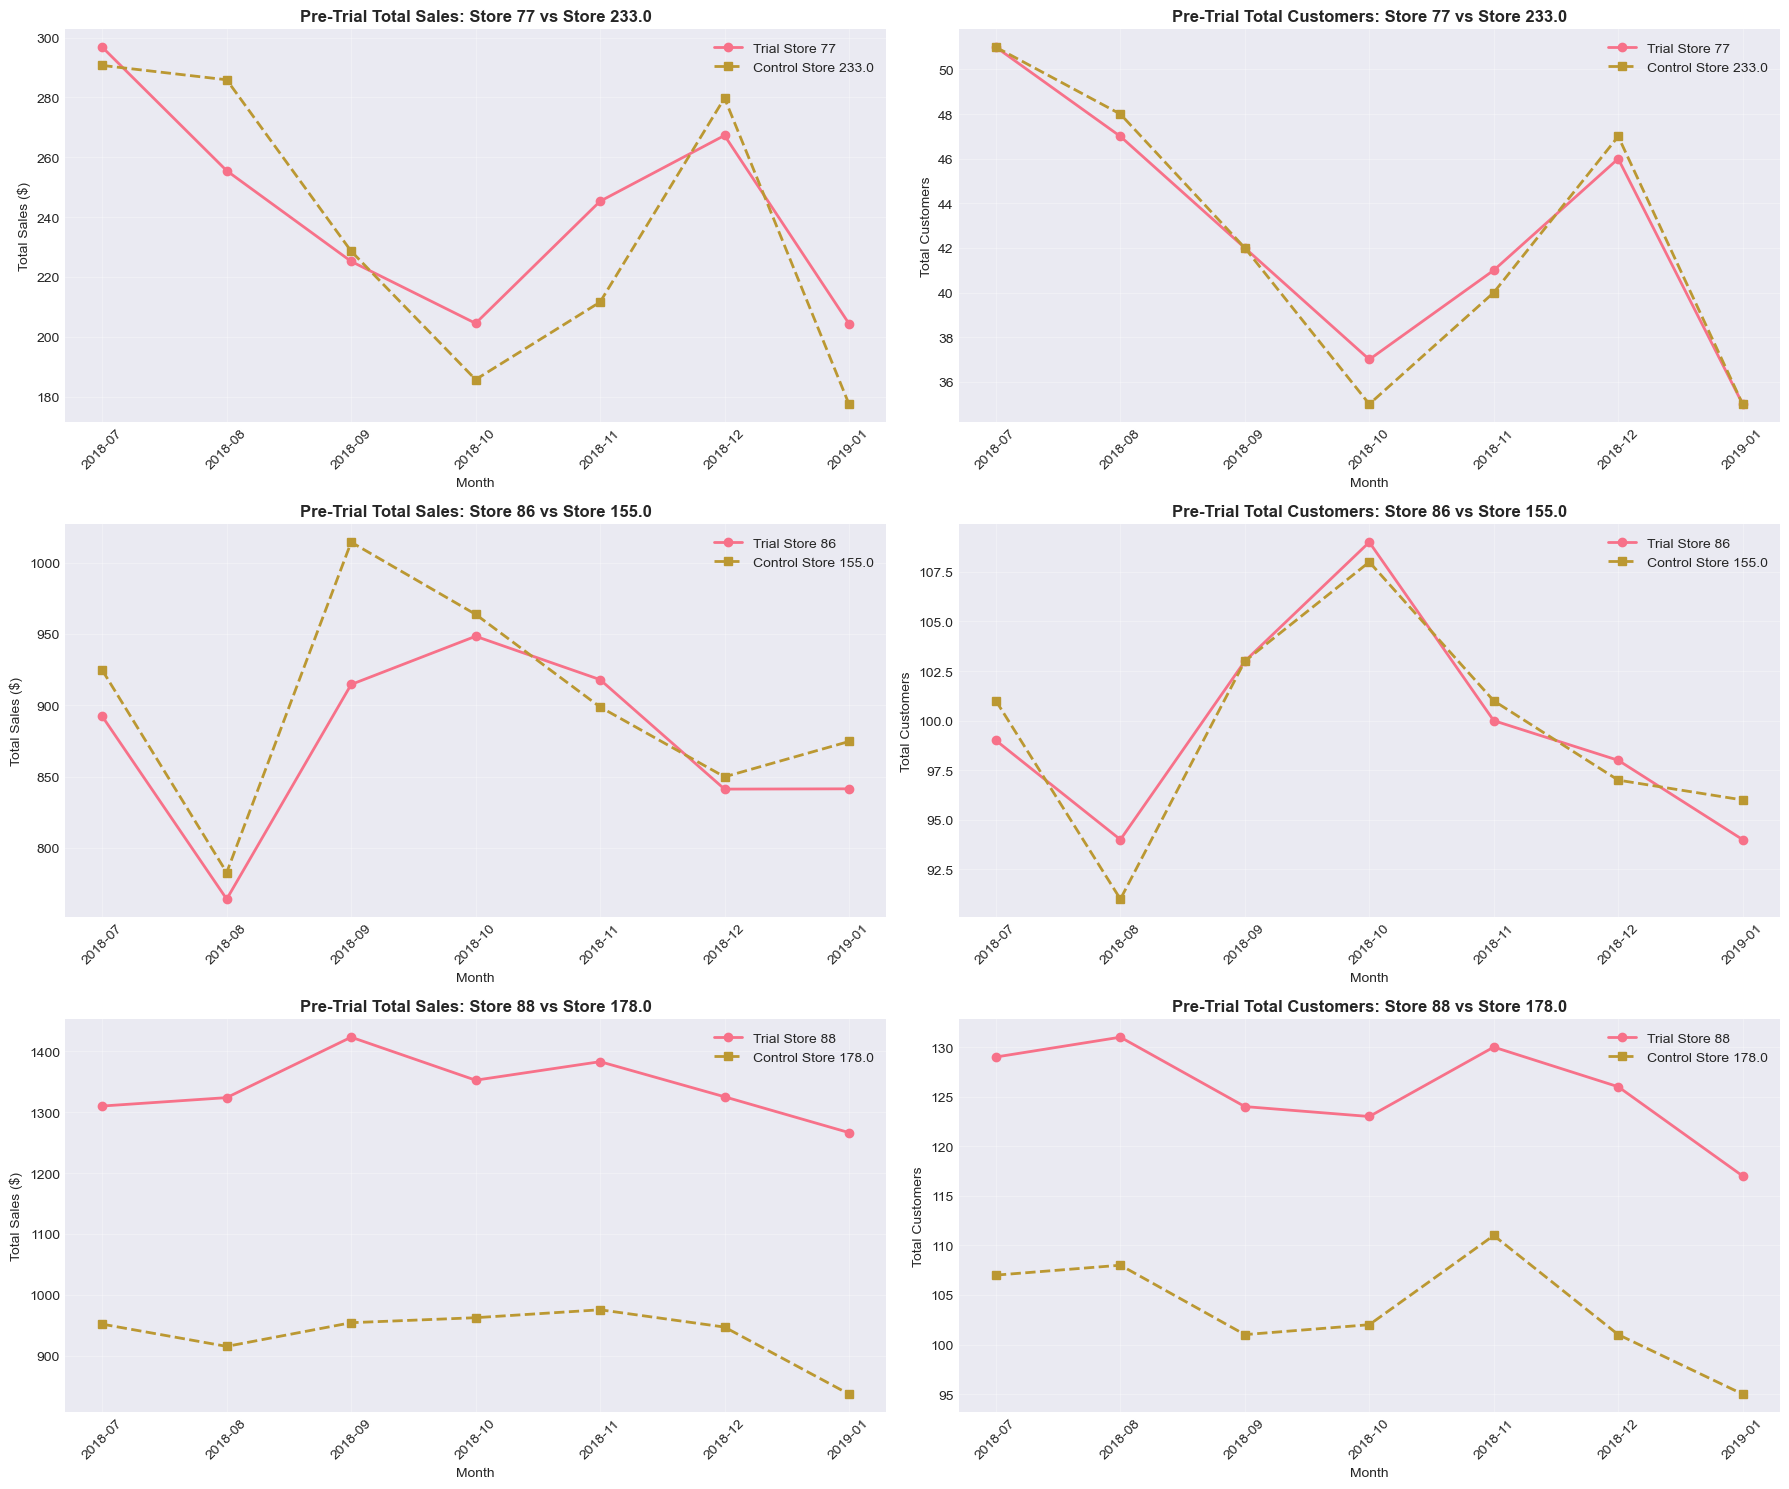

In [27]:
# Create comparison plots for pre-trial period
fig, axes = plt.subplots(len(trial_stores), 2, figsize=(18, 5*len(trial_stores)))

for idx, trial_store in enumerate(trial_stores):
    control_store = control_store_mapping[trial_store]
    
    # Get pre-trial data
    trial_data = monthly_store_metrics[
        (monthly_store_metrics['STORE_NBR'] == trial_store) &
        (monthly_store_metrics['YEARMONTH'].isin(pre_trial_months))
    ].sort_values('YEARMONTH')
    
    control_data = monthly_store_metrics[
        (monthly_store_metrics['STORE_NBR'] == control_store) &
        (monthly_store_metrics['YEARMONTH'].isin(pre_trial_months))
    ].sort_values('YEARMONTH')
    
    # Plot 1: Total Sales
    ax1 = axes[idx, 0] if len(trial_stores) > 1 else axes[0]
    ax1.plot(trial_data['YEARMONTH'].astype(str), trial_data['total_sales'], 
             marker='o', label=f'Trial Store {trial_store}', linewidth=2)
    ax1.plot(control_data['YEARMONTH'].astype(str), control_data['total_sales'], 
             marker='s', label=f'Control Store {control_store}', linewidth=2, linestyle='--')
    ax1.set_title(f'Pre-Trial Total Sales: Store {trial_store} vs Store {control_store}', 
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Total Sales ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Total Customers
    ax2 = axes[idx, 1] if len(trial_stores) > 1 else axes[1]
    ax2.plot(trial_data['YEARMONTH'].astype(str), trial_data['total_customers'], 
             marker='o', label=f'Trial Store {trial_store}', linewidth=2)
    ax2.plot(control_data['YEARMONTH'].astype(str), control_data['total_customers'], 
             marker='s', label=f'Control Store {control_store}', linewidth=2, linestyle='--')
    ax2.set_title(f'Pre-Trial Total Customers: Store {trial_store} vs Store {control_store}', 
                  fontsize=12, fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Total Customers')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('pre_trial_comparison.png', dpi=300, bbox_inches='tight')
print("✓ Saved pre-trial comparison to 'pre_trial_comparison.png'")
plt.show()

## 8. Analyze Trial Period Performance

Now let's compare the trial stores against their control stores during the trial period.

In [28]:
# Function to calculate percentage difference
def calculate_trial_metrics(trial_store, control_store):
    """
    Compare trial and control stores during trial period
    """
    # Get trial period data
    trial_data = monthly_store_metrics[
        (monthly_store_metrics['STORE_NBR'] == trial_store) &
        (monthly_store_metrics['YEARMONTH'].isin(trial_months))
    ]
    
    control_data = monthly_store_metrics[
        (monthly_store_metrics['STORE_NBR'] == control_store) &
        (monthly_store_metrics['YEARMONTH'].isin(trial_months))
    ]
    
    # Calculate totals
    trial_total_sales = trial_data['total_sales'].sum()
    control_total_sales = control_data['total_sales'].sum()
    
    trial_total_customers = trial_data['total_customers'].sum()
    control_total_customers = control_data['total_customers'].sum()
    
    trial_total_transactions = trial_data['total_transactions'].sum()
    control_total_transactions = control_data['total_transactions'].sum()
    
    # Calculate percentage differences
    sales_diff = ((trial_total_sales - control_total_sales) / control_total_sales) * 100
    customers_diff = ((trial_total_customers - control_total_customers) / control_total_customers) * 100
    transactions_diff = ((trial_total_transactions - control_total_transactions) / control_total_transactions) * 100
    
    # Calculate transactions per customer
    trial_txn_per_cust = trial_total_transactions / trial_total_customers
    control_txn_per_cust = control_total_transactions / control_total_customers
    txn_per_cust_diff = ((trial_txn_per_cust - control_txn_per_cust) / control_txn_per_cust) * 100
    
    return {
        'trial_store': trial_store,
        'control_store': control_store,
        'trial_total_sales': round(trial_total_sales, 2),
        'control_total_sales': round(control_total_sales, 2),
        'sales_diff_pct': round(sales_diff, 2),
        'trial_total_customers': trial_total_customers,
        'control_total_customers': control_total_customers,
        'customers_diff_pct': round(customers_diff, 2),
        'trial_total_transactions': trial_total_transactions,
        'control_total_transactions': control_total_transactions,
        'transactions_diff_pct': round(transactions_diff, 2),
        'trial_txn_per_cust': round(trial_txn_per_cust, 2),
        'control_txn_per_cust': round(control_txn_per_cust, 2),
        'txn_per_cust_diff_pct': round(txn_per_cust_diff, 2)
    }

# Calculate metrics for all trial stores
trial_results = []
for trial_store in trial_stores:
    control_store = control_store_mapping[trial_store]
    results = calculate_trial_metrics(trial_store, control_store)
    trial_results.append(results)

trial_results_df = pd.DataFrame(trial_results)

print("\nTrial Period Performance Comparison:")
print("="*80)
display(trial_results_df)


Trial Period Performance Comparison:


,trial_store,control_store,trial_total_sales,control_total_sales,sales_diff_pct,trial_total_customers,control_total_customers,customers_diff_pct,trial_total_transactions,control_total_transactions,transactions_diff_pct,trial_txn_per_cust,control_txn_per_cust,txn_per_cust_diff_pct
0,77,233.0,777.0,601.7,29.13,142,115,23.48,148,121,22.31,1.04,1.05,-0.94
1,86,155.0,2788.2,2540.2,9.76,327,288,13.54,408,368,10.87,1.25,1.28,-2.35
2,88,178.0,4286.8,3147.4,36.20,386,338,14.20,486,440,10.45,1.26,1.30,-3.28


## 9. Statistical Significance Testing

We'll perform t-tests to determine if the differences are statistically significant.

In [29]:
def perform_significance_test(trial_store, control_store, metric='total_sales'):
    """
    Perform independent t-test to check if trial period shows significant difference
    """
    # Get trial period data
    trial_data = monthly_store_metrics[
        (monthly_store_metrics['STORE_NBR'] == trial_store) &
        (monthly_store_metrics['YEARMONTH'].isin(trial_months))
    ][metric].values
    
    control_data = monthly_store_metrics[
        (monthly_store_metrics['STORE_NBR'] == control_store) &
        (monthly_store_metrics['YEARMONTH'].isin(trial_months))
    ][metric].values
    
    # Perform t-test
    t_stat, p_value = stats.ttest_ind(trial_data, control_data)
    
    # Determine significance
    is_significant = p_value < 0.05
    
    return {
        't_statistic': round(t_stat, 4),
        'p_value': round(p_value, 4),
        'is_significant': is_significant,
        'interpretation': 'Significant difference' if is_significant else 'No significant difference'
    }

# Perform significance tests
print("\nStatistical Significance Testing (α = 0.05):")
print("="*80)

for trial_store in trial_stores:
    control_store = control_store_mapping[trial_store]
    
    print(f"\nTrial Store {trial_store} vs Control Store {control_store}:")
    print("-"*80)
    
    # Test for sales
    sales_test = perform_significance_test(trial_store, control_store, 'total_sales')
    print(f"\nTotal Sales:")
    print(f"  t-statistic: {sales_test['t_statistic']}")
    print(f"  p-value: {sales_test['p_value']}")
    print(f"  Result: {sales_test['interpretation']}")
    
    # Test for customers
    customers_test = perform_significance_test(trial_store, control_store, 'total_customers')
    print(f"\nTotal Customers:")
    print(f"  t-statistic: {customers_test['t_statistic']}")
    print(f"  p-value: {customers_test['p_value']}")
    print(f"  Result: {customers_test['interpretation']}")
    
    # Test for transactions per customer
    txn_test = perform_significance_test(trial_store, control_store, 'avg_transactions_per_customer')
    print(f"\nAvg Transactions per Customer:")
    print(f"  t-statistic: {txn_test['t_statistic']}")
    print(f"  p-value: {txn_test['p_value']}")
    print(f"  Result: {txn_test['interpretation']}")


Statistical Significance Testing (α = 0.05):

Trial Store 77 vs Control Store 233.0:
--------------------------------------------------------------------------------

Total Sales:
  t-statistic: 2.1044
  p-value: 0.1031
  Result: No significant difference

Total Customers:
  t-statistic: 1.9385
  p-value: 0.1246
  Result: No significant difference

Avg Transactions per Customer:
  t-statistic: -0.343
  p-value: 0.7489
  Result: No significant difference

Trial Store 86 vs Control Store 155.0:
--------------------------------------------------------------------------------

Total Sales:
  t-statistic: 1.4277
  p-value: 0.2266
  Result: No significant difference

Total Customers:
  t-statistic: 3.806
  p-value: 0.019
  Result: Significant difference

Avg Transactions per Customer:
  t-statistic: -0.7559
  p-value: 0.4918
  Result: No significant difference

Trial Store 88 vs Control Store 178.0:
--------------------------------------------------------------------------------

Total Sale

## 10. Visualize Trial Period Results

✓ Saved trial period analysis to 'trial_period_analysis.png'


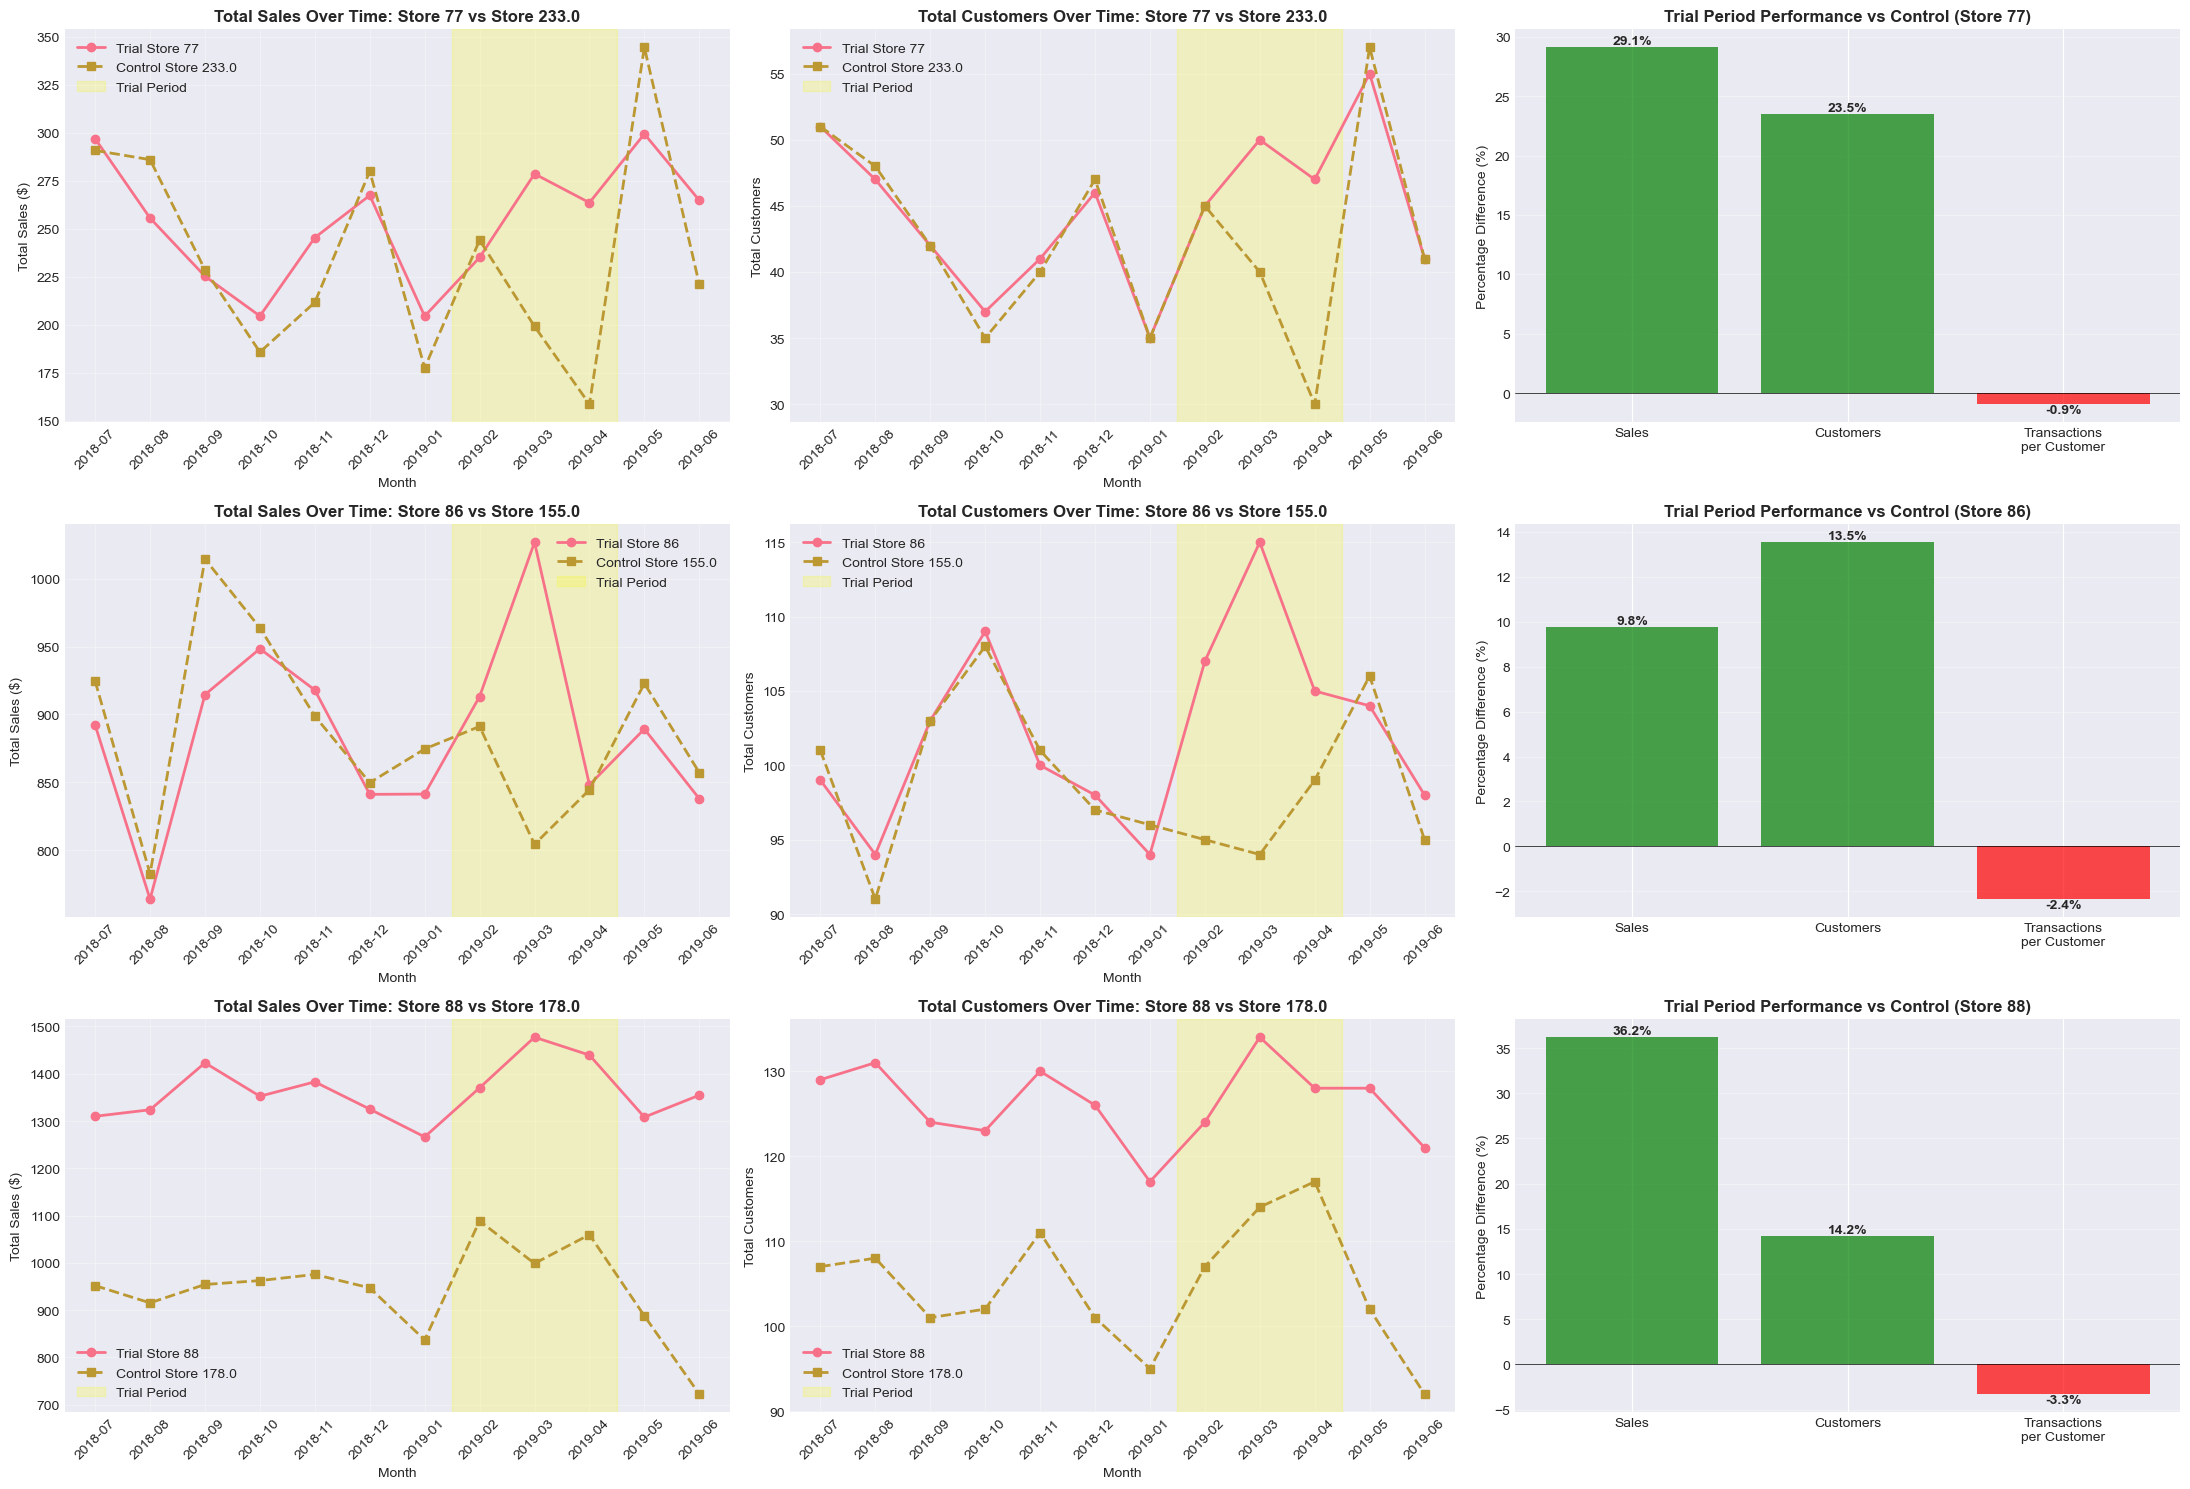

In [30]:
# Create comprehensive trial period comparison
fig, axes = plt.subplots(len(trial_stores), 3, figsize=(22, 5*len(trial_stores)))

for idx, trial_store in enumerate(trial_stores):
    control_store = control_store_mapping[trial_store]
    
    # Get full time series (pre-trial + trial)
    trial_full = monthly_store_metrics[
        monthly_store_metrics['STORE_NBR'] == trial_store
    ].sort_values('YEARMONTH')
    
    control_full = monthly_store_metrics[
        monthly_store_metrics['STORE_NBR'] == control_store
    ].sort_values('YEARMONTH')
    
    # Mark trial period
    trial_start_idx = trial_full[trial_full['YEARMONTH'] == trial_months[0]].index[0]
    
    # Plot 1: Total Sales with trial period highlighted
    ax1 = axes[idx, 0] if len(trial_stores) > 1 else axes[0]
    ax1.plot(trial_full['YEARMONTH'].astype(str), trial_full['total_sales'], 
             marker='o', label=f'Trial Store {trial_store}', linewidth=2)
    ax1.plot(control_full['YEARMONTH'].astype(str), control_full['total_sales'], 
             marker='s', label=f'Control Store {control_store}', linewidth=2, linestyle='--')
    
    # Highlight trial period
    trial_x_start = len(pre_trial_months)
    ax1.axvspan(trial_x_start - 0.5, trial_x_start + len(trial_months) - 0.5, 
                alpha=0.2, color='yellow', label='Trial Period')
    
    ax1.set_title(f'Total Sales Over Time: Store {trial_store} vs Store {control_store}', 
                  fontsize=12, fontweight='bold')
    ax1.set_xlabel('Month')
    ax1.set_ylabel('Total Sales ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Plot 2: Total Customers
    ax2 = axes[idx, 1] if len(trial_stores) > 1 else axes[1]
    ax2.plot(trial_full['YEARMONTH'].astype(str), trial_full['total_customers'], 
             marker='o', label=f'Trial Store {trial_store}', linewidth=2)
    ax2.plot(control_full['YEARMONTH'].astype(str), control_full['total_customers'], 
             marker='s', label=f'Control Store {control_store}', linewidth=2, linestyle='--')
    ax2.axvspan(trial_x_start - 0.5, trial_x_start + len(trial_months) - 0.5, 
                alpha=0.2, color='yellow', label='Trial Period')
    ax2.set_title(f'Total Customers Over Time: Store {trial_store} vs Store {control_store}', 
                  fontsize=12, fontweight='bold')
    ax2.set_xlabel('Month')
    ax2.set_ylabel('Total Customers')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Plot 3: Percentage Difference During Trial
    ax3 = axes[idx, 2] if len(trial_stores) > 1 else axes[2]
    result = trial_results_df[trial_results_df['trial_store'] == trial_store].iloc[0]
    
    metrics = ['Sales', 'Customers', 'Transactions\nper Customer']
    differences = [
        result['sales_diff_pct'],
        result['customers_diff_pct'],
        result['txn_per_cust_diff_pct']
    ]
    
    colors = ['green' if x > 0 else 'red' for x in differences]
    bars = ax3.bar(metrics, differences, color=colors, alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax3.set_title(f'Trial Period Performance vs Control (Store {trial_store})', 
                  fontsize=12, fontweight='bold')
    ax3.set_ylabel('Percentage Difference (%)')
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, val in zip(bars, differences):
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width()/2., height,
                f'{val:.1f}%',
                ha='center', va='bottom' if height > 0 else 'top',
                fontweight='bold')

plt.tight_layout()
plt.savefig('trial_period_analysis.png', dpi=300, bbox_inches='tight')
print("✓ Saved trial period analysis to 'trial_period_analysis.png'")
plt.show()

## 11. Summary of Findings and Recommendations

In [31]:
print("\n" + "="*80)
print("STORE TRIAL EVALUATION - SUMMARY OF FINDINGS")
print("="*80)

for idx, trial_store in enumerate(trial_stores):
    result = trial_results_df.iloc[idx]
    control_store = result['control_store']
    
    print(f"\n📊 TRIAL STORE {trial_store} (Control: Store {control_store})")
    print("-"*80)
    
    print(f"\n1. SALES PERFORMANCE:")
    print(f"   Trial Store Sales: ${result['trial_total_sales']:,.2f}")
    print(f"   Control Store Sales: ${result['control_total_sales']:,.2f}")
    print(f"   Difference: {result['sales_diff_pct']:+.2f}%")
    
    if result['sales_diff_pct'] > 0:
        print(f"    Trial store OUTPERFORMED control by ${result['trial_total_sales'] - result['control_total_sales']:,.2f}")
    else:
        print(f"    Trial store UNDERPERFORMED control by ${abs(result['trial_total_sales'] - result['control_total_sales']):,.2f}")
    
    print(f"\n2. CUSTOMER METRICS:")
    print(f"   Trial Store Customers: {result['trial_total_customers']:,}")
    print(f"   Control Store Customers: {result['control_total_customers']:,}")
    print(f"   Difference: {result['customers_diff_pct']:+.2f}%")
    
    print(f"\n3. TRANSACTION BEHAVIOR:")
    print(f"   Trial Store Transactions: {result['trial_total_transactions']:,}")
    print(f"   Control Store Transactions: {result['control_total_transactions']:,}")
    print(f"   Trial Store Txn/Customer: {result['trial_txn_per_cust']:.2f}")
    print(f"   Control Store Txn/Customer: {result['control_txn_per_cust']:.2f}")
    print(f"   Difference: {result['txn_per_cust_diff_pct']:+.2f}%")
    
    print(f"\n4. DRIVER ANALYSIS:")
    if abs(result['customers_diff_pct']) > abs(result['txn_per_cust_diff_pct']):
        print(f"   Primary driver: CUSTOMER COUNT (more/fewer customers visiting)")
        print(f"   Customer change ({result['customers_diff_pct']:+.2f}%) > Transaction frequency change ({result['txn_per_cust_diff_pct']:+.2f}%)")
    else:
        print(f"   Primary driver: TRANSACTION FREQUENCY (customers shopping more/less often)")
        print(f"   Transaction frequency change ({result['txn_per_cust_diff_pct']:+.2f}%) > Customer change ({result['customers_diff_pct']:+.2f}%)")

print(f"\n\n" + "="*80)
print(" STRATEGIC RECOMMENDATIONS")
print("="*80)

recommendations = [
    "\n1. SUCCESSFUL TRIAL ELEMENTS:",
    "   • Identify which specific interventions in trial stores drove positive results",
    "   • Document operational changes, promotional activities, and layout modifications",
    "   • Prepare rollout plan for successful elements to other stores",
    "",
    "2. CUSTOMER ACQUISITION vs. RETENTION:",
    "   • If customer count increased: Focus on acquisition strategies that worked",
    "   • If transaction frequency increased: Focus on loyalty and repeat visit drivers",
    "   • Analyze which customer segments showed the most change",
    "",
    "3. PERFORMANCE MONITORING:",
    "   • Continue monitoring trial stores post-trial to ensure sustained performance",
    "   • Set up KPI dashboards tracking sales, customers, and transaction frequency",
    "   • Compare against control stores for ongoing benchmarking",
    "",
    "4. SCALE-UP CONSIDERATIONS:",
    "   • Conduct cost-benefit analysis for rolling out trial interventions",
    "   • Prioritize stores with similar characteristics to successful trial stores",
    "   • Phase rollout to manage risk and resource allocation",
    "",
    "5. FURTHER ANALYSIS:",
    "   • Deep dive into product mix changes during trial period",
    "   • Analyze time-of-day and day-of-week patterns",
    "   • Examine customer demographics for trial vs. control stores",
    "   • Conduct customer surveys to understand behavioral drivers"
]

for rec in recommendations:
    print(rec)

print("\n" + "="*80)
print("ANALYSIS COMPLETE!")
print("="*80)


STORE TRIAL EVALUATION - SUMMARY OF FINDINGS

📊 TRIAL STORE 77 (Control: Store 233.0)
--------------------------------------------------------------------------------

1. SALES PERFORMANCE:
   Trial Store Sales: $777.00
   Control Store Sales: $601.70
   Difference: +29.13%
    Trial store OUTPERFORMED control by $175.30

2. CUSTOMER METRICS:
   Trial Store Customers: 142.0
   Control Store Customers: 115.0
   Difference: +23.48%

3. TRANSACTION BEHAVIOR:
   Trial Store Transactions: 148.0
   Control Store Transactions: 121.0
   Trial Store Txn/Customer: 1.04
   Control Store Txn/Customer: 1.05
   Difference: -0.94%

4. DRIVER ANALYSIS:
   Primary driver: CUSTOMER COUNT (more/fewer customers visiting)
   Customer change (+23.48%) > Transaction frequency change (-0.94%)

📊 TRIAL STORE 86 (Control: Store 155.0)
--------------------------------------------------------------------------------

1. SALES PERFORMANCE:
   Trial Store Sales: $2,788.20
   Control Store Sales: $2,540.20
   Diffe

## 12. Export Results

In [32]:
# Save trial results
trial_results_df.to_csv('trial_store_results.csv', index=False)
print(" Saved trial results to 'trial_store_results.csv'")

# Save monthly metrics
monthly_store_metrics.to_csv('monthly_store_metrics.csv', index=False)
print(" Saved monthly metrics to 'monthly_store_metrics.csv'")

# Save control store mapping
control_mapping_df = pd.DataFrame([
    {'trial_store': k, 'control_store': v} 
    for k, v in control_store_mapping.items()
])
control_mapping_df.to_csv('control_store_mapping.csv', index=False)
print(" Saved control store mapping to 'control_store_mapping.csv'")

print("\n📁 Output files created:")
print("   1. trial_store_results.csv - Summary of trial period performance")
print("   2. monthly_store_metrics.csv - All monthly store metrics")
print("   3. control_store_mapping.csv - Trial to control store mapping")
print("   4. pre_trial_comparison.png - Pre-trial period visualizations")
print("   5. trial_period_analysis.png - Trial period analysis visualizations")

 Saved trial results to 'trial_store_results.csv'
 Saved monthly metrics to 'monthly_store_metrics.csv'
 Saved control store mapping to 'control_store_mapping.csv'

📁 Output files created:
   1. trial_store_results.csv - Summary of trial period performance
   2. monthly_store_metrics.csv - All monthly store metrics
   3. control_store_mapping.csv - Trial to control store mapping
   4. pre_trial_comparison.png - Pre-trial period visualizations
   5. trial_period_analysis.png - Trial period analysis visualizations
